# Evaluate the Performance of Firsov on Other Trajectories
The goal here is to compare against our ML model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
from sklearn.linear_model import LinearRegression
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the Tools
We'll need the data for these trajectories and a new model

In [2]:
with open(os.path.join('..', 'data', 'new_data.pkl'), 'rb') as fp:
    new_data = pkl.load(fp)

In [3]:
start_frame = pkl.load(open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb'))

In [4]:
with open(os.path.join('..', 'traj_computer.pkl'), 'rb') as fp:
    traj_computer = pkl.load(fp)

In [5]:
with open('firsov.pkl', 'rb') as fp:
    firsov = pkl.load(fp)

In [6]:
new_data['channel'] = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

In [7]:
new_data['random'] = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

## Run the Model on Each Trajectory
Use the model stored with the trajectory computer, which was trained on the random and channel trajectories

In [8]:
%%time
for subset in new_data.values():
    subset['force_pred_ml'] = traj_computer.model.predict(subset[traj_computer.featurizers.feature_labels()])
    subset['force_pred_firsov'] = np.squeeze(firsov.featurize_many(subset[['position', 'velocity']], pbar=False))

CPU times: user 1min 21s, sys: 1.45 s, total: 1min 23s
Wall time: 2min 52s


## Compare the Model Accuracy
Get a sense for how well this model performed

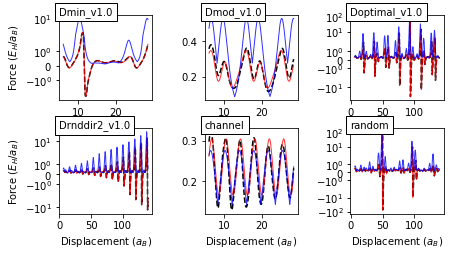

In [9]:
fig, axs = plt.subplots(2, 3)

for i, (ax, (d, subset)) in enumerate(zip(axs.flatten(), new_data.items())):
    subset = subset[~ subset['initial']]
    ax.plot(subset['displacement'], subset['force'], 'k--')
    ax.plot(subset['displacement'], subset['force_pred_ml'], 'r', lw=1, alpha=0.8)
    ax.plot(subset['displacement'], subset['force_pred_firsov'], 'b', lw=1, alpha=0.8)
    
    if subset['force'].max() > 1:
        ax.set_yscale('symlog')
    
    # Make a label for the figure
    ax.text(0, 1, d, bbox={'facecolor': 'w', 'edgecolor': 'k'},
           transform=ax.transAxes)
    
# Make axes labels
for ax in axs[-1, :]:
    ax.set_xlabel('Displacement ($a_B$)')
for ax in axs[:, 0]:
    ax.set_ylabel('Force ($E_H / a_B$)')

fig.tight_layout()
fig.set_size_inches(6.5, 3.5)
fig.savefig(os.path.join('figures', 'validation-set.png'), dpi=320)

*Finding*: Storng qualitative agreement with the stopping forces

# Compute Stopping Power for Channels
Two of the calculations are aligned along crystallographic axes. As such, we need to determine the stopping power along one repeat of the unit cell

## Make a Trajectory Computer for the Firsov Model
The TrajecotryIntegrator class has some useful utilities, and needs an ML model to work. As the output from the Firsov model is our desired force, we'll just make a $f(x) = x$ model using sklearn's linear model

In [10]:
firsov_linreg = LinearRegression()
firsov_linreg.coef_ = np.array([1])
firsov_linreg.intercept_ = 0

In [11]:
traj_computer_firsov = TrajectoryIntegrator(start_frame, firsov_linreg, firsov)

In [12]:
def get_channel_stopping_power(data, direction, traj_computer):
    """Get the stopping power along a channel
    
    Args:
        data (DataFrame): TD-DFT data for a certain channel trajectory
        direction ([int]): Directions in lattice coordinates
        traj_computer (TrajectoryIntegrator): Tool used to compute the stopping force
    Returns:
        - (float) Stopping power from TD-DFT
        - (float) Stopping power from the trajecotry computer
    """
    
    # Get the length of the channel
    length = np.linalg.norm(traj_computer._compute_trajectory(direction))
    
    # Average over all possible choices
    max_distance = data['displacement'].max() - length
    stops = [
        data.query('displacement >= {} and displacement <= {}'.format(x['displacement'], x['displacement'] + length))['force'].mean()
        for i, x in data.query('displacement < {}'.format(max_distance)).iterrows()
    ]
    return np.median(stops), traj_computer.compute_stopping_power(data.iloc[0]['position'], direction, 1, abserr=1e-4)

Print out the results of each channel direction

In [13]:
channels = {
    'Dmod_v1.0': [2, 1, 1],
    'Dmin_v1.0': [1, 2, 2],
    'channel': [1, 0, 0]
}

In [14]:
for key, direct in channels.items():
    tddft, (ml, ml_err) = get_channel_stopping_power(new_data[key], direct, traj_computer)
    tddft, (firsov, firsov_err) = get_channel_stopping_power(new_data[key], direct, traj_computer_firsov)
    
    print('{}: TD-DFT: {:.3f} - ML {:.3f} - Firsov {:.3f}'.format(key, tddft, ml, firsov))

Dmod_v1.0: TD-DFT: 0.234 - ML 0.233 - Firsov 0.341
Dmin_v1.0: TD-DFT: 0.268 - ML 0.245 - Firsov 4.109
channel: TD-DFT: 0.220 - ML 0.234 - Firsov 0.232


*Finding*: We overestimate the channel, and under estimate the random directions

## Compare the Ordering of Stopping Powers
See how well ML and TD-DFT match up

In [15]:
results = []
for key, subset in new_data.items():
    subset = subset[~ subset['initial']]
    results.append({'name': key, 
                    'tddft': subset['force'].mean(),
                    'ml': subset['force_pred_ml'].mean(),
                    'firsov': subset['force_pred_firsov'].mean()})
results = pd.DataFrame(results)

In [16]:
results

,name,tddft,ml,firsov
0,Dmin_v1.0,0.270083,0.260794,1.469153
1,Dmod_v1.0,0.241831,0.237271,0.356485
2,Doptimal_v1.0,0.240920,0.242884,1.936151
3,Drnddir2_v1.0,0.248845,0.249989,1.261054
4,channel,0.221916,0.234292,0.220528
5,random,0.240193,0.238360,1.424013


Make a comparison with a broken axis

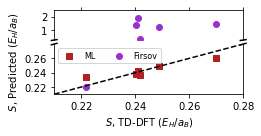

In [17]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.5, 1.8), gridspec_kw={'height_ratios': [0.6, 1]})
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

outlier_start = 0.28
min_value = 0.21
max_value = 0.28

# Put all points on lower axes
axs[1].scatter(results['tddft'], results['ml'], marker='s', label='ML', color='firebrick')
axs[1].scatter(results['tddft'], results['firsov'], label='Firsov', color='darkorchid')

subset = results.query(f'firsov > {outlier_start}')
#axs[0].scatter(subset['tddft'], subset['ml'], label='ML')
axs[0].scatter(subset['tddft'], subset['firsov'], label='Firsov', color='darkorchid')

# Set the ranges for each
for ax in axs:
    ax.set_xlim([min_value, max_value])
axs[1].set_ylim([min_value, max_value])
axs[0].set_ylim([outlier_start, 2.5])
axs[1].set_yticks([0.22, 0.24, 0.26])

# hide the spines between ax and ax2
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].xaxis.tick_top()
axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()

axs[1].plot(ax.get_xlim(), ax.get_xlim(), 'k--')

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

axs[1].set_xlabel('$S$, TD-DFT ($E_H / a_B$)')
axs[1].set_ylabel('     $S$, Predicted ($E_H / a_B$)')
axs[1].legend(ncol=2, fontsize=8)

fig.subplots_adjust(0.2, 0.25, 0.95, 0.9)
fig.savefig(os.path.join('figures', 'stopping-power-comparison.png'), dpi=320)
fig.savefig(os.path.join('figures', 'stopping-power-comparison.pdf'))

*Finding*: Firsov model is terrible compared to ML